In [1]:
%load_ext autoreload
%autoreload 2

In [22]:
### Initial imports
import logging
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as T
import matplotlib.pyplot as plt

logging.basicConfig(level=logging.INFO)
log = logging.getLogger(__name__)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from epimodel.pymc3_models import cm_effect
from epimodel.pymc3_models.cm_effect.datapreprocessor import DataPreprocessorV2

%matplotlib inline

In [23]:
# name, epidemicforecasting.org code, OxCGRT code
region_info = [
    ("Andorra", "AD", "AND"),
    ("Austria", "AT",  "AUT"),
    ("Bosnia and Herzegovina", "BA", "BIH"),
    ("Belgium", "BE", "BEL"),
    ("Bulgaria",  "BG", "BGR"),
    ("Switzerland", "CH", "CHE"),
    ("Czech Republic", "CZ", "CZE"),
    ("Germany", "DE", "DEU"),
    ("Denmark", "DK", "DNK"),
    ("Estonia","EE", "EST"),
    ("Spain", "ES", "ESP"),
    ("Finland", "FI", "FIN"),
    ("France", "FR", "FRA"),
    ("United Kingdom", "GB", "GBR"),
    ("Greece", "GR", "GRC"),
    ("Croatia", "HR", "HRV"),
    ("Hungary", "HU", "HUN"),
    ("Ireland", "IE", "IRL"),
    ("Israel", "IL", "ISR"),
    ("Iceland", "IS", "ISL"),
    ("Italy", "IT", "ITA"),
    ("South Korea", "KR", "KOR"),
    ("Morocco", "MA", "MAR"),
    ("Mexico","MX", "MEX"),
    #("Malaysia", "MY", "MYS"),
    ("Netherlands", "NL", "NLD"),
    ("Poland","PL", "POL"),
    ("Romania","RO", "ROU"),
    ("Serbia", "RS", "SRB"),
    ("Sweden", "SE", "SWE"),
    ("Singapore", "SG", "SGP"),
    ("Slovenia", "SI", "SVN"),
    ("Slovakia", "SK", "SVK"),
    ("South Africa", "ZA",  "ZAF")
]

# OxCGRT
oxcgrt_cm_cols = ["C1_School closing", "C1_Flag", "C4_Restrictions on gatherings", "C4_Flag", "C6_Stay at home requirements",
              "C6_Flag", "H2_Testing policy", "H3_Contact tracing"]

oxcgrt_filter = [
    ("Symptomatic Testing", [(6, [2, 3])]),
    ("Public Testing", [(6, [3])]),
    ("Limited Contact Tracing", [(7, [2, 3])]),
    ("Extensive Contact Tracing", [(7, [2, 3])]),
    ("Gatherings lim. 1000", [(2, [2, 3, 4]), (3, [1])]),
    ("Gatherings lim. 100", [(2, [3, 4]), (3, [1])] ),
    ("Gatherings lim. 10", [(2, [4]), (3, [1])] ),
    ("Some Schools Closed", [(0, [3, 2]), (1, [1])]),
    ("All Schools Closed", [(0, [3]), (1, [1])] ),
    ("Stay at Home, Rec", [(4, [1, 2, 3]), (5, [1])] ),
    ("Stay at Home, Req", [(4, [2, 3]), (5, [1])] ),
]

epifor_features = [
 'Mask wearing over 70%',
 'Business suspended - some',
 'Business suspended - many',
 'Healthcare specialisation'
]

final_features_ordered = [
    "Healthcare specialisation",
    "Symptomatic Testing",
    "Public Testing",
    "Limited Contact Tracing",
    "Extensive Contact Tracing",
    "Mask wearing over 70%",
    "Gatherings lim. 1000", 
    "Gatherings lim. 100",
    "Gatherings lim. 10", 
    "Business suspended - some",
    "Business suspended - many",
    "Some Schools Closed",
    "All Schools Closed", 
    "Stay at Home, Rec", 
    "Stay at Home, Req",
]

dp = DataPreprocessorV2(min_num_confirmed_mask=100, min_num_active_mask=100, end_date="2020-04-20")

INFO:epimodel.regions:Name index has 7 potential conflicts: ['american samoa', 'georgia', 'guam', 'northern mariana islands', 'puerto rico', 'united states minor outlying islands', 'virgin islands (u.s.)']
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:
Countermeasures: Epidemic Forecasting              min   ... mean  ... max   ... unique
 1 Mask wearing over 70%                      0.000 ... 0.062 ... 1.000 ... [0. 1.]
 2 Business suspended - some                  0.000 ... 0.272 ... 1.000 ... [0. 1.]
 3 Business suspended - many                  0.000 ... 0.197 ... 1.000 ... [0. 1.]
 4 Healthcare specialisation                  0.000 ... 0.056 ... 1.000 ... [0. 1.]
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:
Countermeasures: OxCGRT           min   ... mean  ... max   ... unique
 1 Symptomatic Testing                        0.000 ... 0.150 ... 1.000 ... [0. 1.]
 2 Public Testing                             0.000 ... 0.324 ... 1.000 ... [0. 1.]
 3 Limited Contact Tr

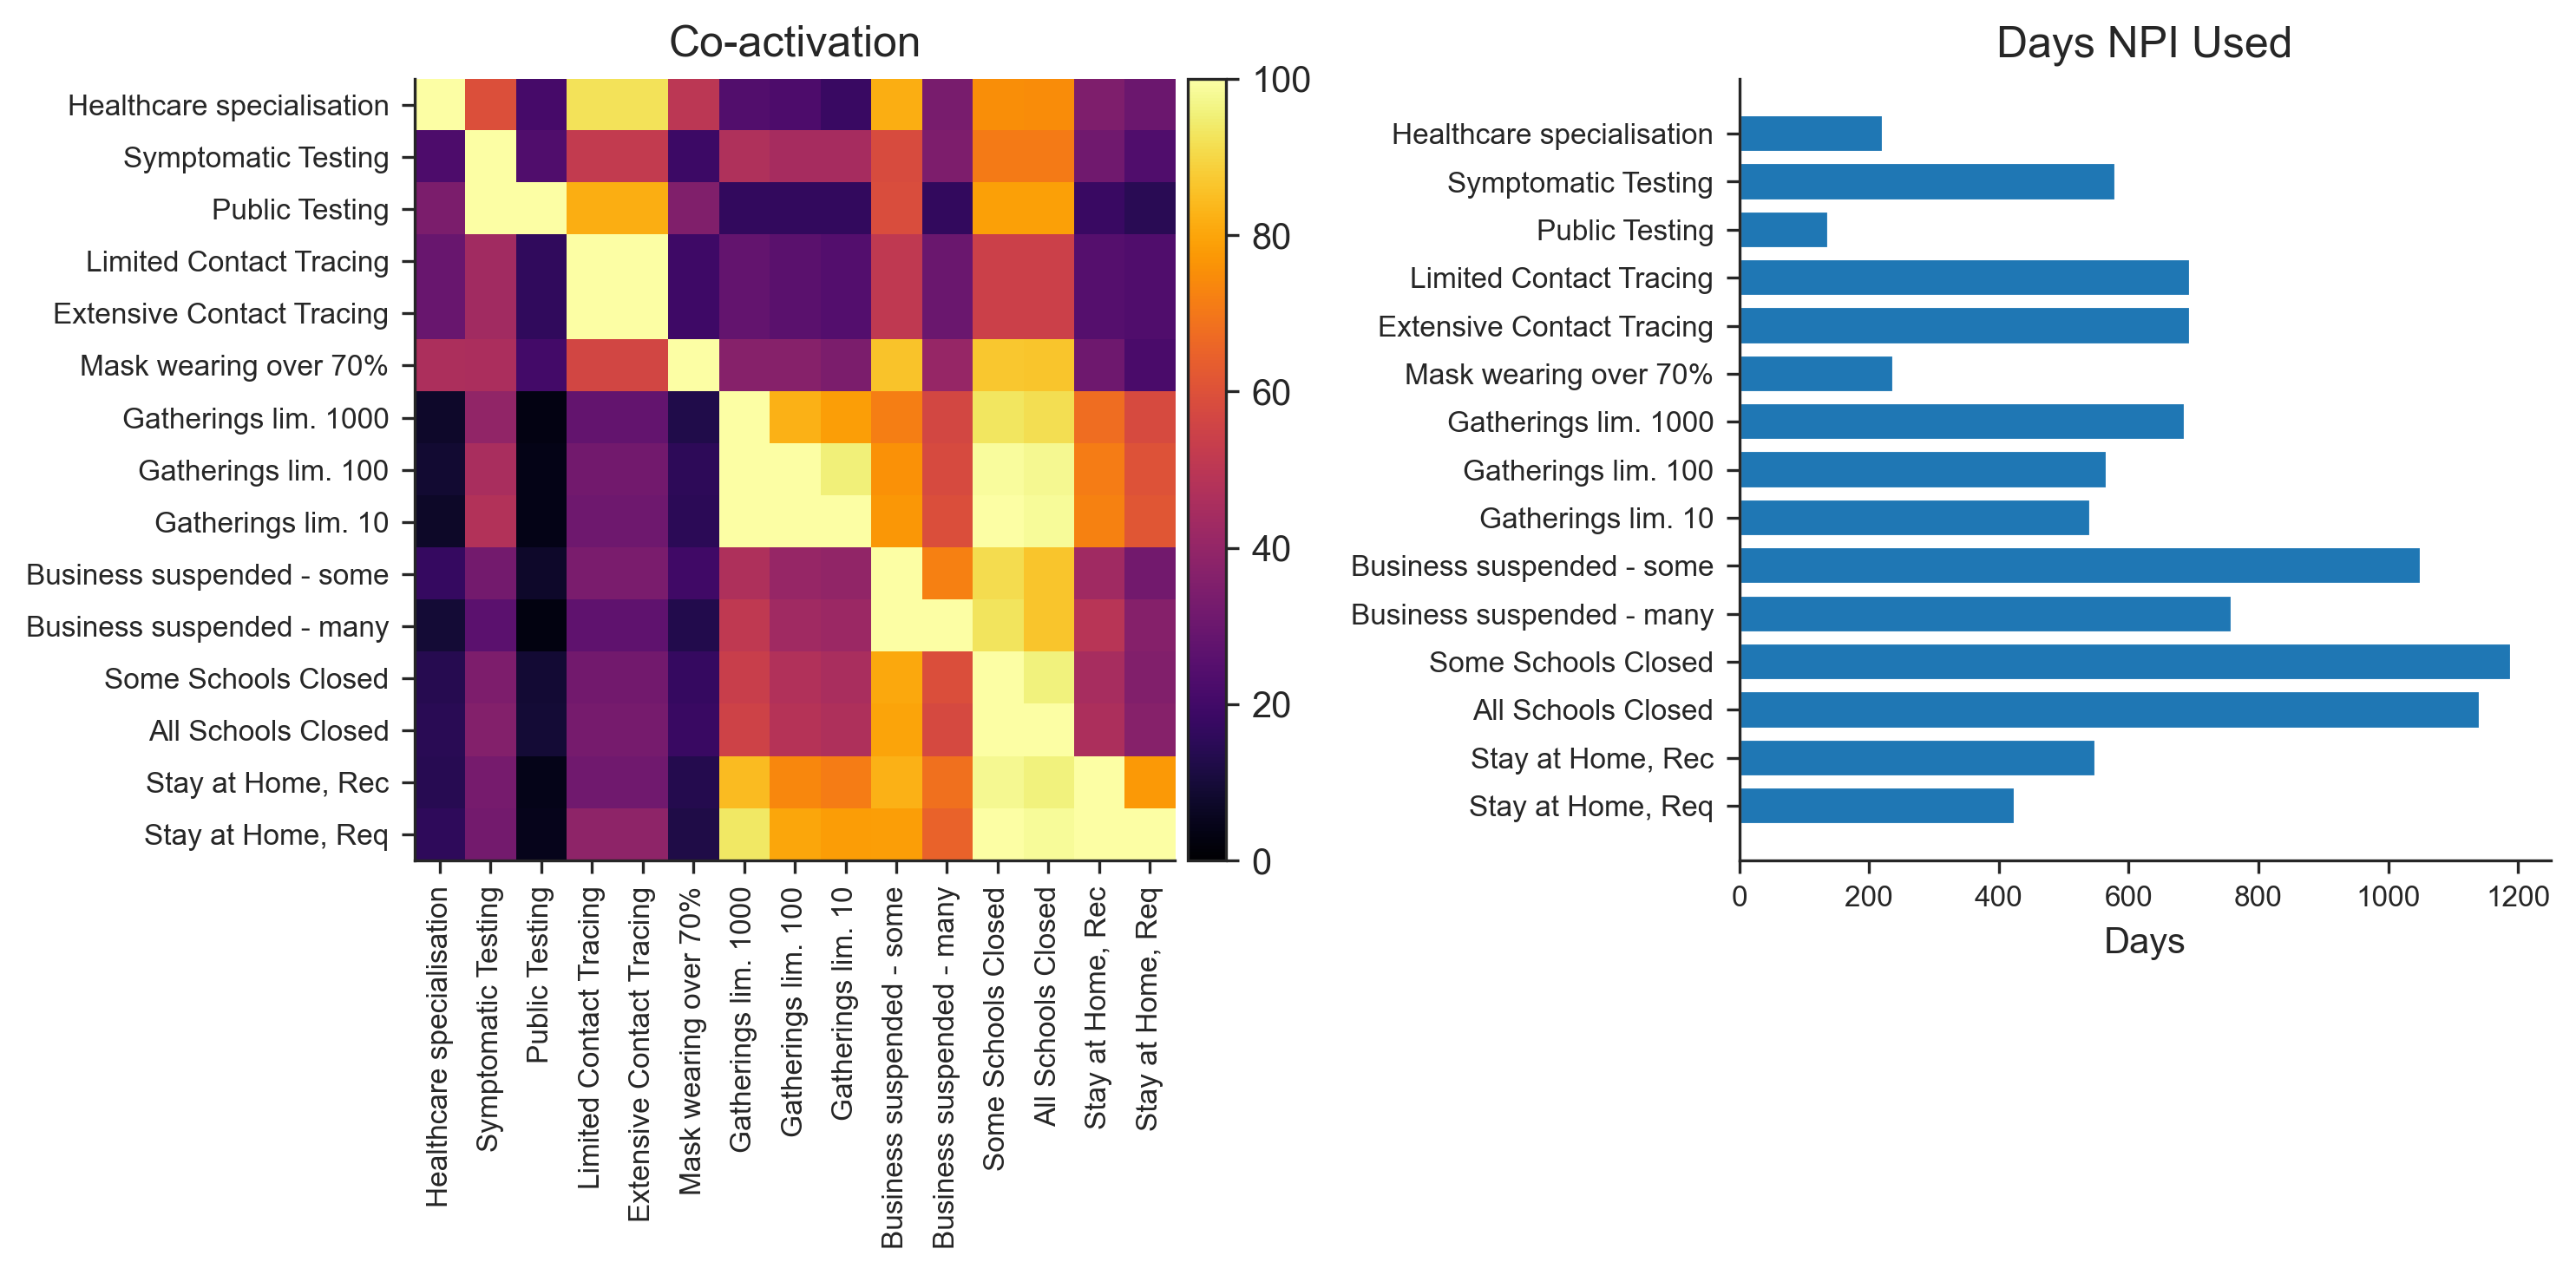

In [24]:
data = dp.preprocess_data("../../data", region_info, oxcgrt_filter, oxcgrt_cm_cols, epifor_features, final_features_ordered)